In [1]:
import polars as pl
from lets_plot import *
from lets_plot.mapping import as_discrete
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn import metrics
from datetime import datetime

LetsPlot.setup_html()


In [15]:
train_data = pl.read_parquet("data/pog-sleep-data/train_dt_fixed.parquet")
train_data.head()

train_data_year = train_data.with_columns(
    [
        pl.col("date").dt.year().alias("year"),
        pl.col("date").dt.day().alias("day"),
        pl.col("date").dt.month().alias("month"),
        pl.col("date").dt.week().alias("week"),
        pl.col("date").dt.weekday().alias("weekday"),
    ]
).with_columns(
    [
        pl.when(pl.col("date").is_between(datetime(2017, 9, 27), datetime(2018, 6, 12)))
        .then(pl.col("sleep_hours") / 2)
        .otherwise(pl.col("sleep_hours"))
        .alias("sleep_hours_normalized")
    ]
)

date_breaks = (
    train_data_year.filter(pl.col("day") == 10).select("date").rows(named=True)
)
date_breaks = [item.get("date") for item in date_breaks]

(
    ggplot(train_data_year, aes("date", "sleep_hours_normalized"))
    + geom_line(aes(group="year", color=as_discrete("year")))
    + scale_x_datetime(breaks=date_breaks, format="%b %d")
    + facet_grid(x="year", scales="free")
    + ggsize(1500, 300)
)


In [12]:
p1 = (
    ggplot()
    + geom_boxplot(
        aes(x="year", y="sleep_hours_normalized", fill=as_discrete("year")),
        data=train_data_year,
        size=2,
        alpha=0.5,
    )
    + scale_x_discrete(name="year")
    + ggtitle("Mean Temperature Aggregated")
    + theme(legend_position="bottom", panel_grid="blank")
)
p2 = (
    ggplot()
    + geom_boxplot(
        aes(x="month", y="sleep_hours_normalized", fill=as_discrete("year")),
        data=train_data_year,
        size=0.75,
        alpha=0.5,
    )
    + scale_x_continuous(breaks=list(range(1, 13)))
    + facet_grid(x="year")
    + ggtitle("Mean Temperature by Month")
    + theme(legend_position="none", panel_grid="blank")
)

w, h = 1000, 300
bunch = GGBunch()
bunch.add_plot(p1, 0, 0, w, h)
bunch.add_plot(p2, 0, h, w, h)
bunch.show()


In [13]:
(
    ggplot(train_data_year, aes("day", "sleep_hours_normalized"))
    + geom_line(
        aes(group="year", color=as_discrete("year")),
        size=2,
        tooltips=layer_tooltips()
        .title("@year")
        .format("@{sleep_hours_normalized}", ".2f")
        .line("@|@{sleep_hours_normalized}")
        .line("date|@month/@day/@year"),
    )
    + scale_x_continuous(breaks=list(range(1, 32)))
    + facet_grid(y="month", scales="free")
    + ylab("month")
    + ggtitle("Mean Temperature for Each Month")
    + theme(legend_position="bottom")
)


In [22]:
train_data_year

date,sleep_hours,year,day,month,week,weekday,sleep_hours_normalized
datetime[μs],f64,i32,u32,u32,u32,u32,f64
2015-02-19 00:00:00,6.4,2015,19,2,8,4,6.4
2015-02-20 00:00:00,7.583333,2015,20,2,8,5,7.583333
2015-02-21 00:00:00,6.35,2015,21,2,8,6,6.35
2015-02-22 00:00:00,6.5,2015,22,2,8,7,6.5
2015-02-23 00:00:00,8.916667,2015,23,2,9,1,8.916667
2015-02-24 00:00:00,6.6,2015,24,2,9,2,6.6
2015-02-25 00:00:00,6.216667,2015,25,2,9,3,6.216667
2015-02-26 00:00:00,5.283333,2015,26,2,9,4,5.283333
2015-02-27 00:00:00,9.866667,2015,27,2,9,5,9.866667


In [28]:
(
    ggplot(
        train_data_year.filter(pl.col("year") == 2021),
        aes("weekday", "sleep_hours_normalized"),
    )
    + geom_line(
        aes(group="week", color=as_discrete("week")),
        size=2,
        tooltips=layer_tooltips()
        .title("@year")
        .format("@{sleep_hours_normalized}", ".2f")
        .line("@|@{sleep_hours_normalized}")
        .line("date|@weekday/@day/@year"),
    )
    + scale_x_continuous(breaks=list(range(1, 9)))
    + facet_grid(y="month", scales="free")
    + ylab("month")
    + ggtitle("Mean Temperature for Each Month")
    + theme(legend_position="bottom")
)


In [33]:
train_data_year

date,sleep_hours,year,day,month,week,weekday,sleep_hours_normalized
datetime[μs],f64,i32,u32,u32,u32,u32,f64
2015-02-19 00:00:00,6.4,2015,19,2,8,4,6.4
2015-02-20 00:00:00,7.583333,2015,20,2,8,5,7.583333
2015-02-21 00:00:00,6.35,2015,21,2,8,6,6.35
2015-02-22 00:00:00,6.5,2015,22,2,8,7,6.5
2015-02-23 00:00:00,8.916667,2015,23,2,9,1,8.916667
2015-02-24 00:00:00,6.6,2015,24,2,9,2,6.6
2015-02-25 00:00:00,6.216667,2015,25,2,9,3,6.216667
2015-02-26 00:00:00,5.283333,2015,26,2,9,4,5.283333
2015-02-27 00:00:00,9.866667,2015,27,2,9,5,9.866667


In [42]:
(
    ggplot(train_data_year.filter(pl.col("year") > 2015), aes(x="sleep_hours_normalized"))
    + geom_histogram(
        aes(group="year", fill=as_discrete("year")),
        color="black",
        bins=15,
        size=0.5,
        alpha=0.5,
        tooltips=layer_tooltips()
        .line("count|@..count..")
        .format("@{sleep_hours_normalized}", ".2f")
        .line("@|@{sleep_hours_normalized}")
        .line("@|@month")
        .line("@|@year"),
    )
    + facet_grid(x="month", y="year", scales="free")
    + xlab("month")
    + ylab("year")
    + ggtitle("Most Common Temperature")
    + ggsize(1000, 500)
    + theme_classic()
    + theme(legend_position="bottom")
)


In [50]:
int_mean_temp_df = train_data_year.select(
    pl.col("sleep_hours_normalized"), pl.col("month"), pl.col("year")
).with_columns(pl.col("sleep_hours_normalized").cast(pl.Int64))

(
    ggplot(
        int_mean_temp_df,
        aes("month", "sleep_hours_normalized", fill="sleep_hours_normalized"),
    )
    + geom_bin2d(
        stat="identity",
        size=0.8,
        color="white",
        alpha=0.2,
        tooltips=layer_tooltips()
        .format("@{sleep_hours_normalized}", ".2f")
        .line("@|@{sleep_hours_normalized}")
        .format("@month", "d")
        .line("@|@month")
        .title("@year"),
    )
    + scale_x_continuous(breaks=list(range(1, 13)))
    + scale_fill_gradient(low="#abd9e9", high="#d7191c")
    + facet_grid(x="year")
    + coord_fixed(ratio=1.2)
    + xlab("")
    + ggtitle("Heatmap of Temperatures by Year")
    + ggsize(1000, 400)
    + theme_classic()
    + theme(legend_position="bottom")
)


In [57]:
int_mean_temp_df = train_data_year.select(
    pl.col("sleep_hours_normalized"), pl.col("weekday"), pl.col("month"), pl.col("year")
).with_columns(pl.col("sleep_hours_normalized").cast(pl.Int64))

(
    ggplot(
        int_mean_temp_df,
        aes("weekday", "sleep_hours_normalized", fill="sleep_hours_normalized"),
    )
    + geom_bin2d(
        stat="identity",
        size=0.8,
        color="white",
        alpha=0.2,
        tooltips=layer_tooltips()
        .format("@{sleep_hours_normalized}", ".2f")
        .line("@|@{sleep_hours_normalized}")
        .format("@month", "d")
        .line("@|@month")
        .title("@year"),
    )
    + scale_x_continuous(breaks=list(range(1, 13)))
    + scale_fill_gradient(low="#abd9e9", high="#d7191c")
    + facet_grid(x="month", y="year")
    + coord_fixed(ratio=0.8)
    + xlab("")
    + ggtitle("Heatmap of Temperatures by Year")
    + ggsize(1000, 800)
    + theme_classic()
    + theme(legend_position="bottom")
)


In [58]:
from pmdarima import tsdisplay

/home/luba/.local/share/virtualenvs/rob-sleep-hour-prediction-OIlHryCd/lib/python3.10/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


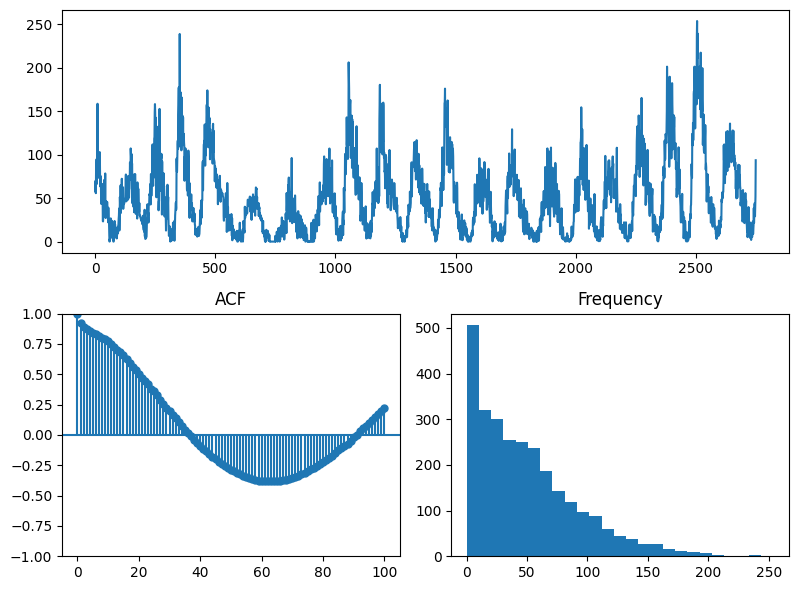

In [64]:
tsdisplay(train_data_year["sleep_hours_normalized"], lag_max=300)

/home/luba/.local/share/virtualenvs/rob-sleep-hour-prediction-OIlHryCd/lib/python3.10/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


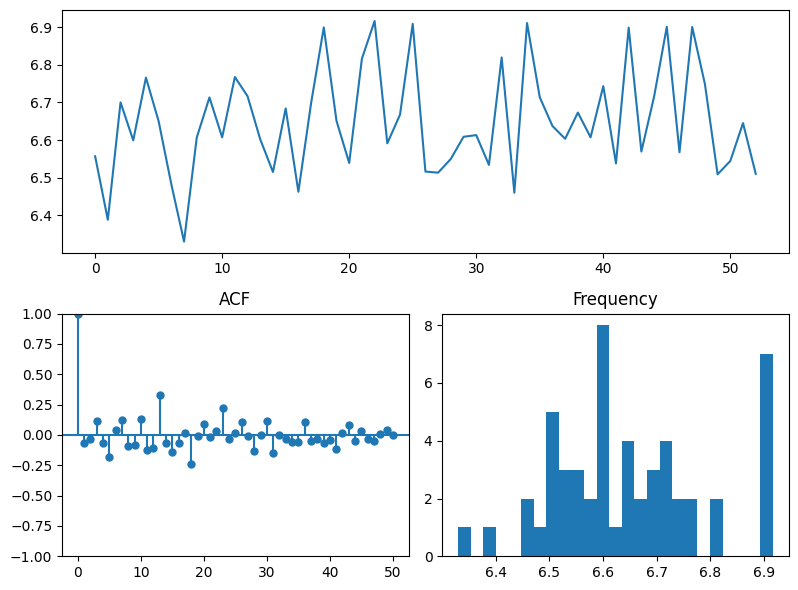

In [74]:
train_data_by_week = train_data_year.groupby("week").agg(
    pl.mean("sleep_hours_normalized").alias("sleep_hours_normalized")
)

tsdisplay(train_data_by_week["sleep_hours_normalized"], lag_max=50)

In [71]:
train_data_by_week

week,year,sleep_hours_normalized
u32,i32,f64
21,2021,6.894048
53,2021,6.038889
38,2021,6.544048
6,2021,6.498611
31,2021,7.016667
24,2021,7.327778
17,2021,6.747222
49,2021,6.62619
2,2021,6.613095
